In [91]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA
from pandas import concat


# Data Import and Cleaning

In [92]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [93]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [94]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [95]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [96]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

# Random Forest

In [97]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [98]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [99]:
rf_data = series_to_supervised(X, n_in=4)

In [100]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

### Walk-forward validation

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [103]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000, random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

>expected=7.5, predicted=15.2
>expected=7.8, predicted=8.6


>expected=3.5, predicted=10.4
>expected=3.9, predicted=7.3
>expected=6.8, predicted=6.6
>expected=2.1, predicted=6.7
MAE: 3.947
ME: 3.900
RMSE: 4.866
Direction Accuracy: 0.000


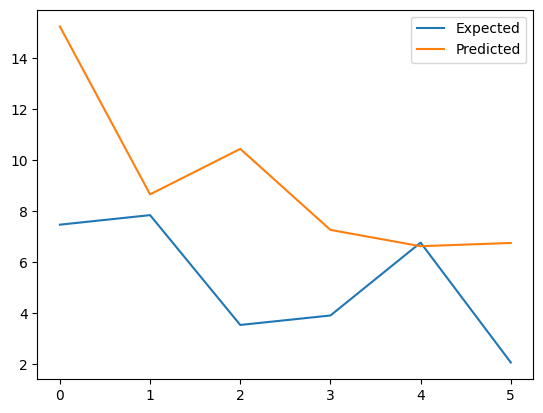

In [104]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_walk_forward_validation(rf_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

### Rolling forecast for Random Forest  

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [105]:
train, test = train_test_split(rf_data, 6)


In [106]:
test

array([[18.51417816, 28.98555411, 16.84723416,  4.06330439,  7.45821383],
       [28.98555411, 16.84723416,  4.06330439,  7.45821383,  7.83274999],
       [16.84723416,  4.06330439,  7.45821383,  7.83274999,  3.52511322],
       [ 4.06330439,  7.45821383,  7.83274999,  3.52511322,  3.89640241],
       [ 7.45821383,  7.83274999,  3.52511322,  3.89640241,  6.75448265],
       [ 7.83274999,  3.52511322,  3.89640241,  6.75448265,  2.0532646 ]])

In [107]:
train = asarray(train)

In [108]:
trainX, trainy = train[:, :-1], train[:, -1]


In [109]:
model_rf_rolling = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf_rolling.fit(trainX, trainy)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [110]:
predictions = list()
direction_accuracies = list() 

In [111]:
for i in range(len(test)):
    print(test[i, :-1])

[18.51417816 28.98555411 16.84723416  4.06330439]
[28.98555411 16.84723416  4.06330439  7.45821383]
[16.84723416  4.06330439  7.45821383  7.83274999]
[4.06330439 7.45821383 7.83274999 3.52511322]
[7.45821383 7.83274999 3.52511322 3.89640241]
[7.83274999 3.52511322 3.89640241 6.75448265]


In [112]:
test

array([[18.51417816, 28.98555411, 16.84723416,  4.06330439,  7.45821383],
       [28.98555411, 16.84723416,  4.06330439,  7.45821383,  7.83274999],
       [16.84723416,  4.06330439,  7.45821383,  7.83274999,  3.52511322],
       [ 4.06330439,  7.45821383,  7.83274999,  3.52511322,  3.89640241],
       [ 7.45821383,  7.83274999,  3.52511322,  3.89640241,  6.75448265],
       [ 7.83274999,  3.52511322,  3.89640241,  6.75448265,  2.0532646 ]])

In [113]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print(testX)
    yhat = model_rf_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[18.51417816 28.98555411 16.84723416  4.06330439]
>expected=7.5, predicted=15.2
[28.98555411 16.84723416  4.06330439  7.45821383]
>expected=7.8, predicted=8.1
[16.84723416  4.06330439  7.45821383  7.83274999]
>expected=3.5, predicted=11.2
[4.06330439 7.45821383 7.83274999 3.52511322]
>expected=3.9, predicted=6.5
[7.45821383 7.83274999 3.52511322 3.89640241]
>expected=6.8, predicted=6.6
[7.83274999 3.52511322 3.89640241 6.75448265]
>expected=2.1, predicted=5.0


In [114]:
yhat

array([4.97428635])

In [115]:
predictions

[array([15.23229585]),
 array([8.05535681]),
 array([11.2197097]),
 array([6.50977701]),
 array([6.62761812]),
 array([4.97428635])]

In [116]:
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

Forecast accuracy for Rolling Forecast with Random Forest
MAE: 3.559
ME: 3.516
RMSE: 4.745
Direction Accuracy: 0.400


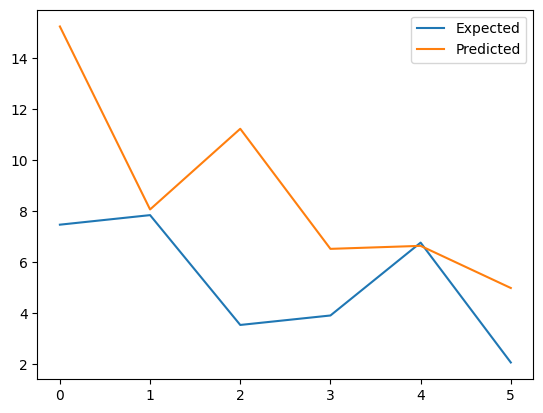

In [118]:
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Rolling Forecast with Random Forest')
print('MAE: %.3f' % error)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a
recursive autoregressive (multi-step) forecaster.

In [35]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [36]:
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4
                )

In [37]:
 y_train = df_train['wPreis']

In [38]:
# Now you can pass y_train to forecaster.fit()
forecaster_rf.fit(y=y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [39]:
predicted_test = forecaster_rf.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [40]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [41]:
predicted_test.index = df_test.index


In [42]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Random Forest Static Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))




Random Forest Static Forecast Accuracy of: wPreis
me     :  9.2806
rmse   :  9.6618
direction_accuracy :  0.4


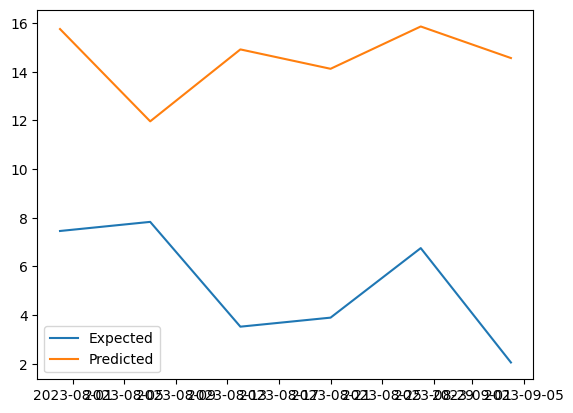

In [43]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()